In [188]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from data_loader.dataLoader import KaggleLoader

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Data Loading

In [2]:
# Loading sample datasets from Kaggle
loader = KaggleLoader("joonasyoon/clustering-exercises")

df_blob = loader.load_csv("blob.csv")
df_dart = loader.load_csv("dart.csv")
df_outliers = loader.load_csv("outliers.csv")
df_spiral2 = loader.load_csv("spiral2.csv")
df_basic2 = loader.load_csv("basic2.csv")
df_boxes3 = loader.load_csv("boxes3.csv")

# Loading online retail dataset
OR_loader = KaggleLoader("hellbuoy/online-retail-customer-clustering")
df_onlineRetail = OR_loader.load_csv_with_encoding("OnlineRetail.csv", 
                                                   encoding = "unicode_escape"
)
df_onlineRetail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### EDA

#### Descriptive statistics

In [3]:
# Checking the shape, data types, and missing values
print(df_onlineRetail.shape)
print(df_onlineRetail.info())
df_onlineRetail.isnull().sum()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Numerical summary of the data
df_onlineRetail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


negative values are probably representing returns.

In [5]:
# Converting InvoiceDate to datetime object
df_onlineRetail['InvoiceDate'] = pd.to_datetime(df_onlineRetail['InvoiceDate'], format="%d-%m-%Y %H:%M")
print(f"The data period spans from {df_onlineRetail["InvoiceDate"].min()} to {df_onlineRetail["InvoiceDate"].max()}")

# Converting CustomerID column into int
df_onlineRetail['CustomerID'] = df_onlineRetail['CustomerID'].astype('Int64')

# Nb of unique customers
print(f"Nb. of unique customers: {df_onlineRetail['CustomerID'].nunique()}")

# Transactions per customer to identify loyal customers
df_onlineRetail.groupby('CustomerID').agg({'InvoiceNo': 'nunique'}).sort_values(by='InvoiceNo', ascending=False)

The data period spans from 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Nb. of unique customers: 4372


,InvoiceNo
CustomerID,
14911,248
12748,224
17841,169
14606,128
13089,118
...,...
13877,1
16400,1
13878,1


In [6]:
# The count of countries in the dataset
df_onlineRetail.groupby('Country').agg({'InvoiceNo': 'count'}).sort_values(by='InvoiceNo', ascending=False).head(10)

,InvoiceNo
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


In [7]:
# Checking quantities with negative values
df_onlineRetail.loc[df_onlineRetail['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


InvoiceNo starting with 'C' represents cancelled transactions.

In [8]:
# Checking unit price with negative values
df_onlineRetail.loc[df_onlineRetail['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,<NA>,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,<NA>,United Kingdom


### Data Cleansing

In [9]:
# Dropping the missing rows on CustomerID column
df_onlineRetail = df_onlineRetail.dropna(subset=['CustomerID'], how='any', ignore_index=True)

# Dropping cancellations from the dataset
print(f"Nb. of rows with negative quantities: {int(df_onlineRetail.loc[df_onlineRetail['Quantity'] < 0, 'InvoiceNo'].count())}")
df_onlineRetail = df_onlineRetail.loc[~df_onlineRetail['InvoiceNo'].astype('str').str.startswith('C')]

# Dropping rows with negative unit prices
print(f"Nb. of rows with negative unit prices: {int(df_onlineRetail.loc[df_onlineRetail['UnitPrice'] < 0, 'InvoiceNo'].count())}")
df_onlineRetail = df_onlineRetail.loc[df_onlineRetail['UnitPrice'] >= 0]

# Dropping any duplicate rows 
df_onlineRetail = df_onlineRetail.drop_duplicates().reset_index(drop=True)

print(f"The shape of the dataset after data cleansing step: {df_onlineRetail.shape}")


Nb. of rows with negative quantities: 8905
Nb. of rows with negative unit prices: 0
The shape of the dataset after data cleansing step: (392732, 8)


#### RFM Feature Engineering

RFM feature engineering step turns the transaction-level data into customer-lever features. 

R: Recency -> how recently a customer purchased

F: Frequency -> how often a customer purchased

M: Monetary -> how much a customer spent

In [10]:
# Generating TotalPrice column
df_onlineRetail['TotalPrice'] = df_onlineRetail['Quantity'] * df_onlineRetail['UnitPrice']

# The date of analysis
report_date = df_onlineRetail['InvoiceDate'].max() + pd.Timedelta(days=1)

# Data aggregation over RFM metrics
rfm = df_onlineRetail.groupby('CustomerID').agg({
    'InvoiceDate': lambda t: (report_date - t.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace = True)

# Dropping zero-monetary customers
rfm = rfm.loc[rfm['Monetary'] > 0]
print(rfm.describe())
rfm

           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272706    2048.688081
std     100.014169     7.706221    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     306.482500
50%      51.000000     2.000000     668.570000
75%     142.000000     5.000000    1660.597500
max     374.000000   210.000000  280206.020000


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40
...,...,...,...
18280,278,1,180.60
18281,181,1,80.82
18282,8,2,178.05


#### Outlier Detection

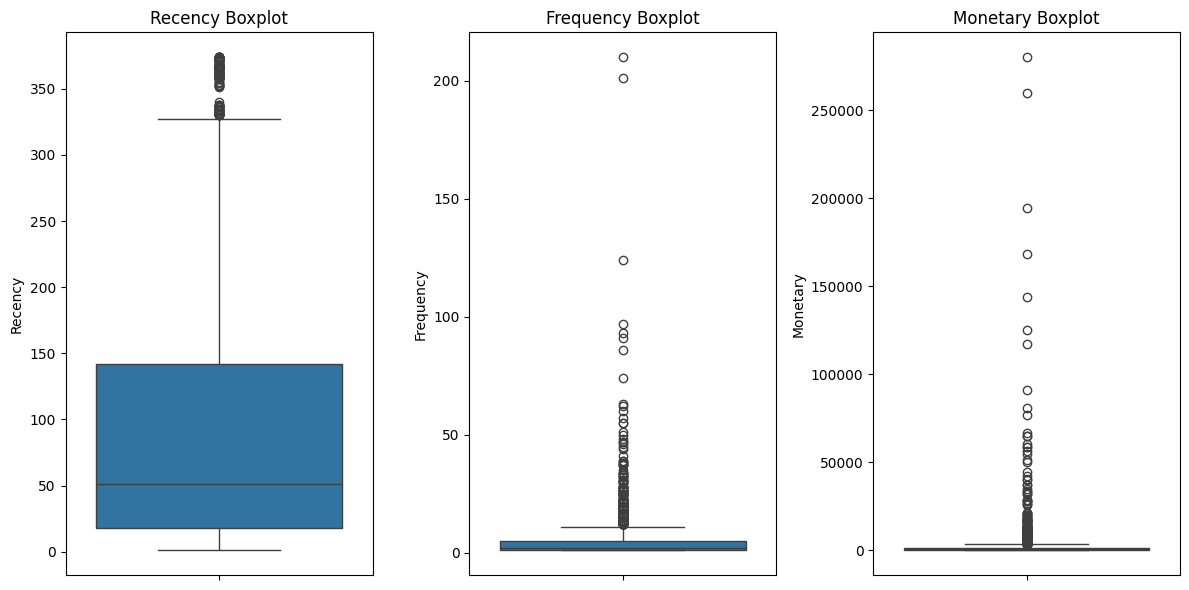

In [11]:
# Boxplot Visualization
fig, ax = plt.subplots(1, 3, figsize = (12,6))

sns.boxplot(y = rfm['Recency'], ax = ax[0])
ax[0].set_title('Recency Boxplot')
sns.boxplot(y = rfm['Frequency'], ax = ax[1])
ax[1].set_title('Frequency Boxplot')
sns.boxplot(y = rfm['Monetary'], ax = ax[2])
ax[2].set_title('Monetary Boxplot')

plt.tight_layout()
plt.show()

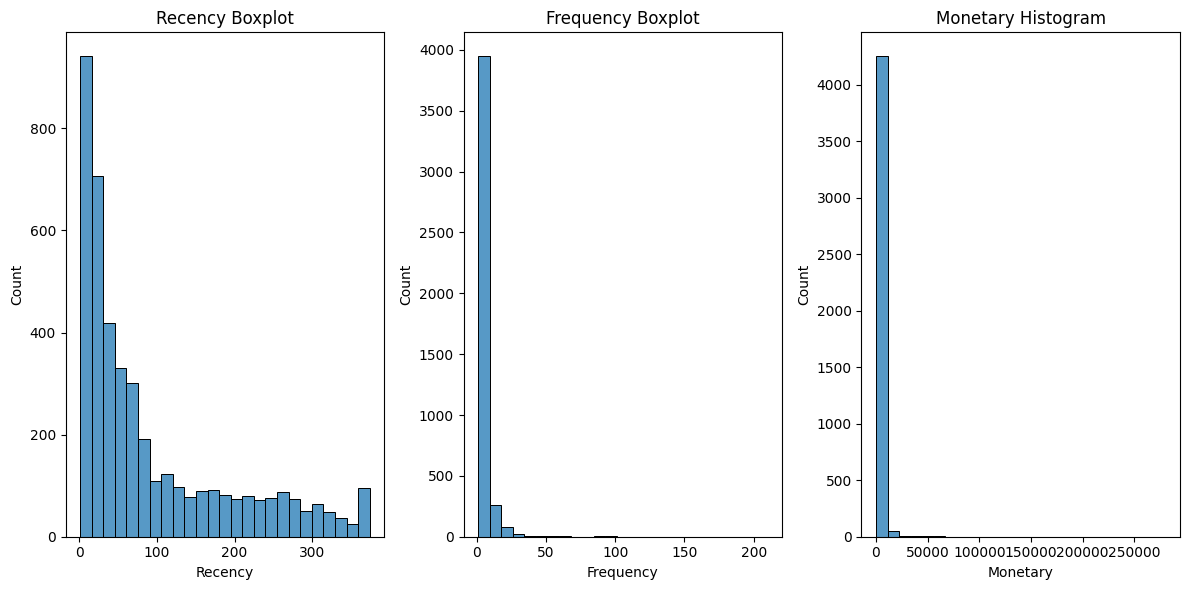

In [12]:
# Histogram Visualization
fig, ax = plt.subplots(1, 3, figsize = (12,6))

sns.histplot(x = rfm['Recency'], bins = 25, ax = ax[0])
ax[0].set_title('Recency Boxplot')
sns.histplot(x = rfm['Frequency'], bins = 25, ax = ax[1])
ax[1].set_title('Frequency Boxplot')
sns.histplot(x = rfm['Monetary'], bins = 25, ax = ax[2])
ax[2].set_title('Monetary Histogram')

plt.tight_layout()
plt.show()

The distributions are not normal, and highly skewed. We also observe on boxplots that there are many outliers in the dataset.

In [13]:
# Using Isolation Forest as an Outlier Detection Algorithm
rfm_if = rfm.copy()

# Log transformation
rfm_if['Recency'] = np.log1p(rfm_if['Recency'])
rfm_if['Frequency'] = np.log1p(rfm_if['Frequency'])
rfm_if['Monetary'] = np.log1p(rfm_if['Monetary'])

# Fitting Isolation Forest
iso_forest = IsolationForest(
    n_estimators = 150,
    contamination = 0.10,
    random_state = 7
) # we assume that almost 10% of the data is composed by outliers

rfm_if['Outlier'] = iso_forest.fit_predict(rfm_if)
print(rfm_if['Outlier'].value_counts())
rfm_if

Outlier
 1    3904
-1     434
Name: count, dtype: int64


,Recency,Frequency,Monetary,Outlier
CustomerID,,,,
12346,5.789960,0.693147,11.253955,-1
12347,1.098612,2.079442,8.368925,1
12348,4.330733,1.609438,7.494564,1
12349,2.995732,0.693147,7.472245,1
12350,5.739793,0.693147,5.815324,1
...,...,...,...,...
18280,5.631212,0.693147,5.201806,1
18281,5.204007,0.693147,4.404522,1
18282,2.197225,1.098612,5.187665,1


Returns -1 for outliers, while 1 for inliers

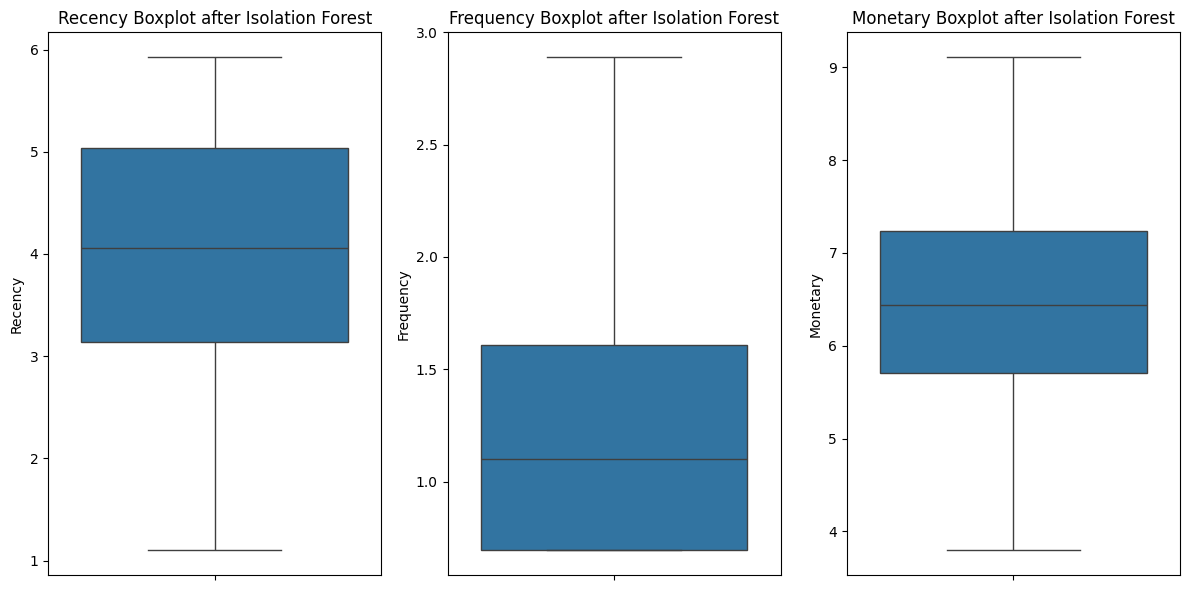

In [14]:
# Dropping the outliers
rfm_clean = rfm_if.loc[rfm_if['Outlier'] == 1].drop(columns=['Outlier'])

# Boxplot Visualization after outlier removal
fig, ax = plt.subplots(1, 3, figsize = (12,6))

sns.boxplot(y = rfm_clean['Recency'], ax = ax[0])
ax[0].set_title('Recency Boxplot after Isolation Forest')
sns.boxplot(y = rfm_clean['Frequency'], ax = ax[1])
ax[1].set_title('Frequency Boxplot after Isolation Forest')
sns.boxplot(y = rfm_clean['Monetary'], ax = ax[2])
ax[2].set_title('Monetary Boxplot after Isolation Forest')

plt.tight_layout()
plt.show()


#### Scaling the Data

We will apply RobustSclaer due to the anomalies in the dataset.

In [15]:
# RobustScaler
scl = RobustScaler()
rfm_scaled = scl.fit_transform(
    rfm_clean[['Recency', 'Frequency', 'Monetary']]
)
rfm_scaled = pd.DataFrame(
    rfm_scaled,
    index = rfm_clean.index,
    columns = ['Recency', 'Frequency', 'Monetary']
)
rfm_scaled

,Recency,Frequency,Monetary
CustomerID,,,
12347,-1.556338,1.070435,1.272520
12348,0.142028,0.557493,0.697577
12349,-0.559468,-0.442507,0.682901
12350,0.882440,-0.442507,-0.406620
12352,-0.236210,1.198978,0.916080
...,...,...,...
18278,0.135068,-0.442507,-0.834762
18280,0.825384,-0.442507,-0.810043
18281,0.600903,-0.442507,-1.334304


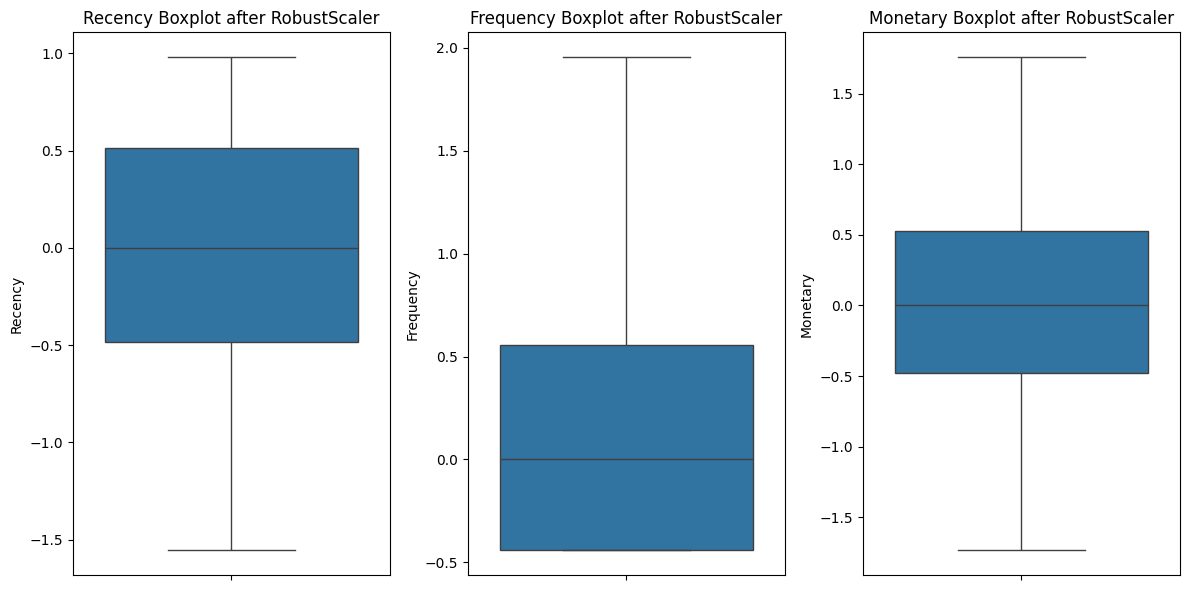

In [16]:
# Boxplot Visualization after RobustScaler
fig, ax = plt.subplots(1, 3, figsize = (12,6))

sns.boxplot(y = rfm_scaled['Recency'], ax = ax[0])
ax[0].set_title('Recency Boxplot after RobustScaler')
sns.boxplot(y = rfm_scaled['Frequency'], ax = ax[1])
ax[1].set_title('Frequency Boxplot after RobustScaler')
sns.boxplot(y = rfm_scaled['Monetary'], ax = ax[2])
ax[2].set_title('Monetary Boxplot after RobustScaler')

plt.tight_layout()
plt.show()

### Data Clustering

#### K-Means

In [17]:
# Fitting KMeans
k_val = list(range(3, 12))
inertia = {} # Within-Cluster Sum of Square

for k in k_val:
    kmeans = KMeans(
        n_clusters = k,
        random_state = 7,
        n_init = 20
    )
    kmeans.fit(rfm_scaled)
    inertia[k] = kmeans.inertia_
inertia

{3: 1726.2077669707007,
 4: 1361.694488859949,
 5: 1146.1071944885914,
 6: 992.2738735471744,
 7: 900.9796944231857,
 8: 824.7462361103394,
 9: 761.9600812142658,
 10: 705.8778466908955,
 11: 658.8946189394596}

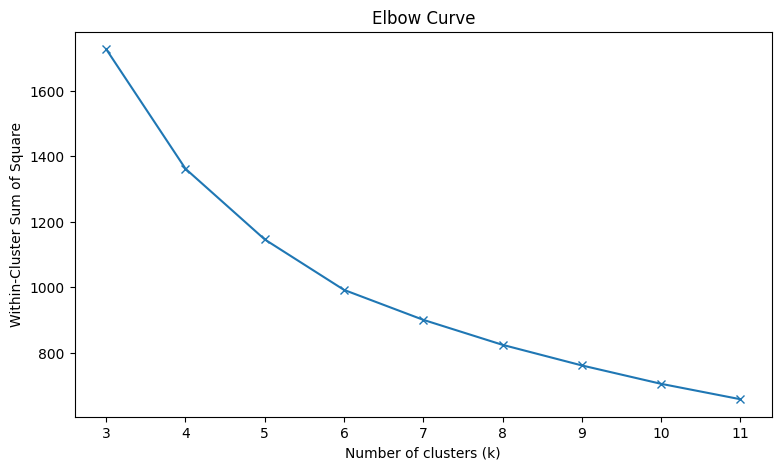

In [18]:
# Plotting Elbow curve
plt.figure(figsize = (9,5))
plt.plot(list(inertia.keys()), list(inertia.values()), marker='x')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('Elbow Curve')
plt.xticks(list(inertia.keys()))
plt.show()

In [19]:
# Let's choose k = 5, and fit KMeans based on k = 5
kmeans = KMeans(
    n_clusters = 5,
    random_state = 7,
    n_init = 20
)

clusters_kmeans = kmeans.fit_predict(rfm_scaled)

# Assigning clusters to rfm 
rfm_final = rfm_clean.copy()
rfm_final['Cluster'] = clusters_kmeans
rfm_final

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12347,1.098612,2.079442,8.368925,4
12348,4.330733,1.609438,7.494564,1
12349,2.995732,0.693147,7.472245,2
12350,5.739793,0.693147,5.815324,0
12352,3.610918,2.197225,7.826858,4
...,...,...,...,...
18278,4.317488,0.693147,5.164214,3
18280,5.631212,0.693147,5.201806,0
18281,5.204007,0.693147,4.404522,0


#### Validation Step

In [20]:
# Silhouette Score
silhouette_scores = {}

for k in k_val:
    kmeans = KMeans(
        n_clusters = k,
        random_state = 7,
        n_init = 20
    )
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores[k] = score
silhouette_scores

{3: 0.32121368154892826,
 4: 0.33546227670990975,
 5: 0.32275309307810324,
 6: 0.3122614376730997,
 7: 0.2878546899180892,
 8: 0.28116808783784314,
 9: 0.2777422007821283,
 10: 0.2791528735274156,
 11: 0.2818640791310529}

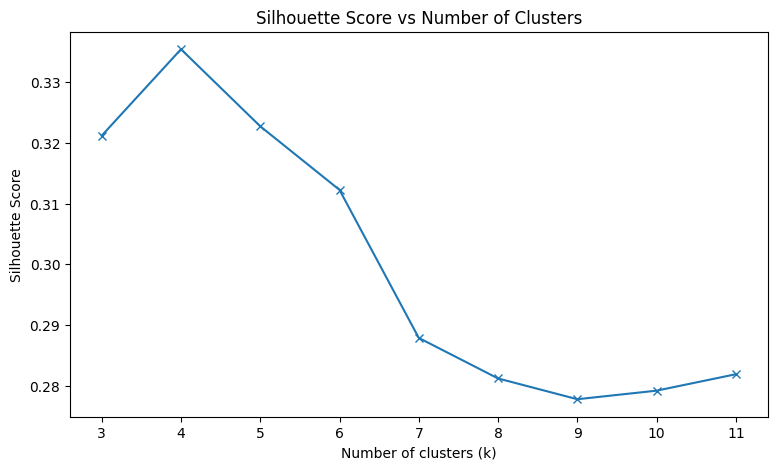

In [21]:
# Plotting Silhouette Score curve
plt.figure(figsize=(9, 5))
plt.plot(
    list(silhouette_scores.keys()),
    list(silhouette_scores.values()),
    marker='x'
)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(list(silhouette_scores.keys()))
plt.show()

#### Cluster Profiling

In [22]:
# Clustering distribution
rfm_final['Cluster'].value_counts()

Cluster
0    907
1    898
4    735
3    724
2    640
Name: count, dtype: int64

In [23]:
# Clustering profile per cluster
rfm_final_per_cluster = rfm_final.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})

# Appending cluster size and percentage to the clustering profile data
clusterSize = rfm_final['Cluster'].value_counts().sort_index()
rfm_final_per_cluster['ClusterSize'] = clusterSize = rfm_final['Cluster'].value_counts().sort_index()
rfm_final_per_cluster['ClusterPerc'] = 100*(clusterSize/clusterSize.sum())

rfm_final_per_cluster

,Recency,Frequency,Monetary,ClusterSize,ClusterPerc
Cluster,,,,,
0,5.412335,0.766722,5.411318,907,23.232582
1,4.619197,1.262649,6.862697,898,23.002049
2,2.728626,1.405684,6.718904,640,16.393443
3,3.673361,0.810357,5.557881,724,18.545082
4,2.926961,2.084422,7.852735,735,18.826844


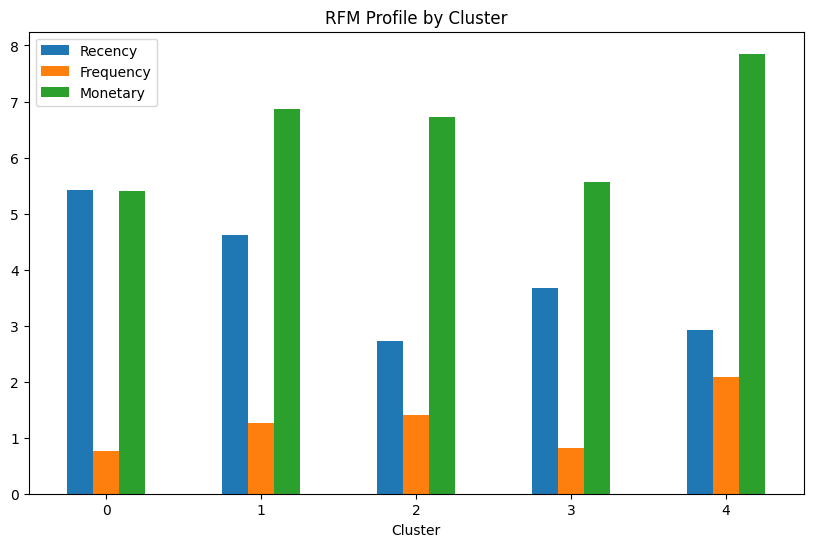

In [24]:
# Visualizing cluster profiles
rfm_final_per_cluster[['Recency', 'Frequency', 'Monetary']].plot(
    kind='bar',
    figsize=(10, 6)
)
plt.title('RFM Profile by Cluster')
plt.xticks(rotation=0)
plt.show()

In [31]:
### Computing RFM score for ordering cluster definitions
"""
Recency -> lower is better -> we need to invert the metric
Frequency -> higher is better
Monetary -> higher is better
"""
rfm_score_df = rfm_final[['Recency', 'Frequency', 'Monetary']].copy()

# Min-max normalization
rfm_score_df['Recency_norm'] = 1 - (
    (rfm_score_df['Recency'] - rfm_score_df['Recency'].min()) /
    (rfm_score_df['Recency'].max() - rfm_score_df['Recency'].min())
)
rfm_score_df['Frequency_norm'] = (
    (rfm_score_df['Frequency'] - rfm_score_df['Frequency'].min()) /
    (rfm_score_df['Frequency'].max() - rfm_score_df['Frequency'].min())
)
rfm_score_df['Monetary_norm'] = (
    (rfm_score_df['Monetary'] - rfm_score_df['Monetary'].min()) /
    (rfm_score_df['Monetary'].max() - rfm_score_df['Monetary'].min())
)
rfm_score_df

# Defining weights for each metric
R_weight, F_weight, M_weight = 1/3, 1/3, 1/3    # Equally weighted

# Computing composite RFM score
rfm_score_df['RFM_score'] = (
    R_weight * rfm_score_df['Recency_norm'] +
    F_weight * rfm_score_df['Frequency_norm'] +
    M_weight * rfm_score_df['Monetary_norm']
)

# Assinging RFM scores to rfm_final dataset
rfm_final['RFM_score'] = rfm_score_df['RFM_score']
rfm_final

,Recency,Frequency,Monetary,Cluster,RFM_score
CustomerID,,,,,
12347,1.098612,2.079442,8.368925,4,0.830548
12348,4.330733,1.609438,7.494564,1,0.481257
12349,2.995732,0.693147,7.472245,2,0.433015
12350,5.739793,0.693147,5.815324,0,0.139629
12352,3.610918,2.197225,7.826858,4,0.640968
...,...,...,...,...,...
18278,4.317488,0.693147,5.164214,3,0.196975
18280,5.631212,0.693147,5.201806,0,0.108638
18281,5.204007,0.693147,4.404522,0,0.088115


In [ ]:
# Assigning business interpretable cluster definitions based on ranking
cluster_rfm_score = rfm_final.groupby('Cluster').agg({'RFM_score': 'mean'}).sort_values(by='RFM_score')
print(cluster_rfm_score)

# Mapping dictionary
ranked_clusters = cluster_rfm_score.index.to_list()
cluster_def = {
    ranked_clusters[0]: 'Shopping Hostage',
    ranked_clusters[1]: 'At Risk',
    ranked_clusters[2]: 'Potential',
    ranked_clusters[3]: 'Loyal',
    ranked_clusters[4]: 'Serial Shopper'
}

# Assigning cluster definitions
rfm_final['Segment'] = rfm_final['Cluster'].map(cluster_def)

# Segment-level summary table
summary_per_segment = rfm_final.groupby('Segment').agg({
    'Cluster': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_score': 'mean'
}).rename(columns = {'Cluster': 'CustomerCount'}).round(2)
summary_per_segment

         RFM_score
Cluster           
0         0.148053
3         0.283921
1         0.369094
2         0.512292
4         0.672697


,CustomerCount,Recency,Frequency,Monetary,RFM_score
Segment,,,,,
At Risk,724,3.67,0.81,5.56,0.28
Loyal,640,2.73,1.41,6.72,0.51
Potential,898,4.62,1.26,6.86,0.37
Serial Shopper,735,2.93,2.08,7.85,0.67
Shopping Hostage,907,5.41,0.77,5.41,0.15


In [58]:
### PCA visualisation with 2 components
# Fitting PCA
pca = PCA(
    n_components = 2,
    random_state = 7
)
rfm_pca = pca.fit_transform(rfm_scaled)

# Converting to dataframe
rfm_pca_df = pd.DataFrame(
    rfm_pca,
    index = rfm_scaled.index,
    columns = ['PC1', 'PC2']    
)

# Appending segments
rfm_pca_df['Segment'] = rfm_final['Segment']

# Explained variance
explained_variance = pca.explained_variance_ratio_
print(f"PC1 explains {explained_variance[0]*100:.2f}% variance")
print(f"PC2 explains {explained_variance[1]*100:.2f}% variance")
print(f"Total explained variance: {explained_variance.sum()*100:.2f}%")

rfm_pca_df

PC1 explains 73.06% variance
PC2 explains 19.90% variance
Total explained variance: 92.96%


,PC1,PC2,Segment
CustomerID,,,
12347,2.104961,-0.518599,Serial Shopper
12348,0.594581,0.557633,Potential
12349,0.362885,-0.224028,Loyal
12350,-1.066014,0.470960,Shopping Hostage
12352,1.290550,0.455174,Serial Shopper
...,...,...,...
18278,-0.976813,-0.376912,At Risk
18280,-1.302449,0.224144,Shopping Hostage
18281,-1.535256,-0.224854,Shopping Hostage


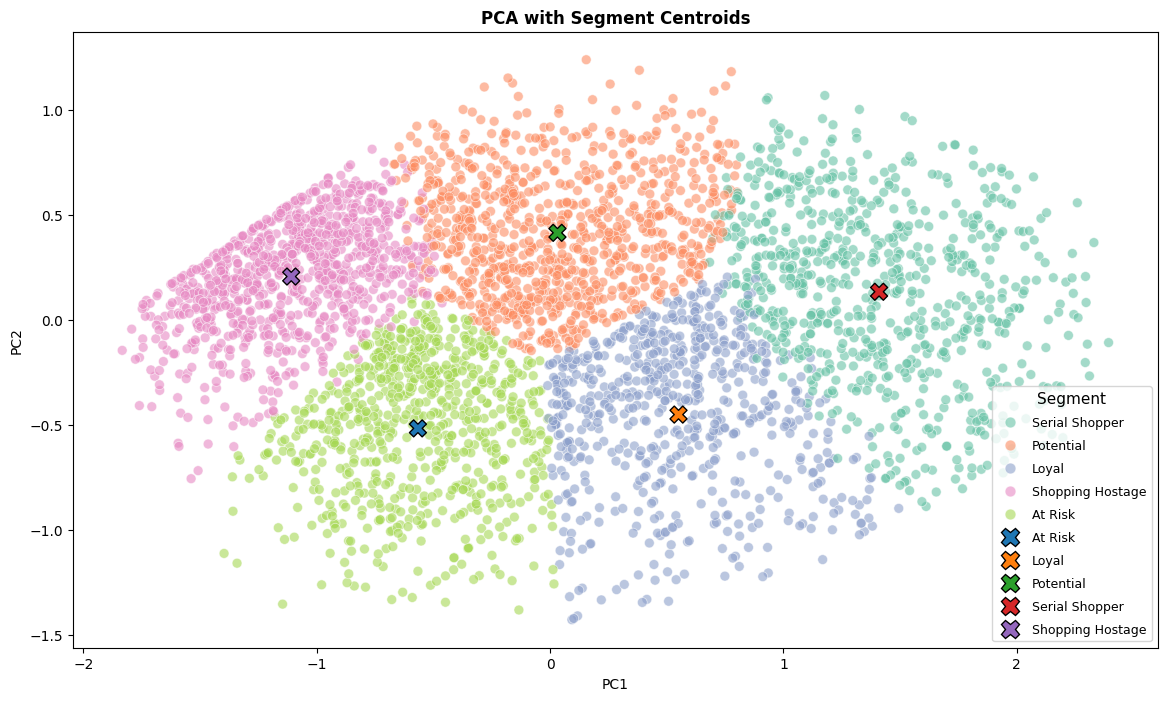

In [186]:
### PCA scatter plot
# Computing centroids 
centroids_pca = rfm_pca_df.groupby('Segment').agg({
    'PC1': 'mean',
    'PC2': 'mean'
}).reset_index()

# scatter plots
plt.figure(figsize = (14,8))

sns.scatterplot(
    data = rfm_pca_df,
    x = 'PC1',
    y = 'PC2',
    hue = 'Segment',
    palette = 'Set2',
    alpha = 0.6,
    s = 50
)

sns.scatterplot(
    data = centroids_pca,
    x = 'PC1',
    y = 'PC2',
    hue = 'Segment',
    marker = 'X',
    edgecolor = 'black',
    s = 150,
    legend = True 
)

plt.title('PCA with Segment Centroids', fontweight = 'bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(
    title = 'Segment',
    fontsize = 9,
    title_fontsize = 11,
    markerscale = 1.1,
    labelspacing = 0.8,
    frameon = True,
    loc = 'best'
)
plt.show()

#### Baseline (K-Means for k = 5)

In [95]:
labels_kmeans = rfm_final['Cluster']
silhouette_kmeans = silhouette_score(rfm_scaled, labels_kmeans)

print(f"KMeans Silhouette Score: {silhouette_kmeans:.4f}")
print(f"Number of clusters: {labels_kmeans.nunique()}")

KMeans Silhouette Score: 0.3228
Number of clusters: 5


#### DBSCAN

In [ ]:
# Fitting DBSCAN
dbscan = DBSCAN(
    eps = 0.25,
    min_samples = 10
) # -1 represents noise, non-negative integers represent cluster membership

labels_dbscan = dbscan.fit_predict(rfm_scaled)

# Attaching labels
rfm_dbscan = rfm_final.copy()
rfm_dbscan['Cluster_dbscan'] = labels_dbscan
print(rfm_dbscan['Cluster_dbscan'].value_counts()) 

# Filtering out noise
mask = labels_dbscan != -1
if mask.sum() > 0 and len(set(labels_dbscan[mask])) > 1:
    silhouette_dbscan = silhouette_score(
        rfm_scaled[mask],
        labels_dbscan[mask]
    )

print(f"DBSCAN Silhouette Score (excluding noise): {silhouette_dbscan:.4f}")
print(f"Nb. of clusters (excluding noise): {len(set(labels_dbscan)) - (1 if -1 in set(labels_dbscan) else 0)}")
print(f"Noise ratio: {100*((labels_dbscan == -1).sum() / labels_dbscan.shape[0]):.4f}")

Cluster_dbscan
 0    1627
 1    1405
 2     794
-1      78
Name: count, dtype: int64
DBSCAN Silhouette Score (excluding noise): 0.2000
Nb. of clusters (excluding noise): 3
Noise ratio: 1.9980%


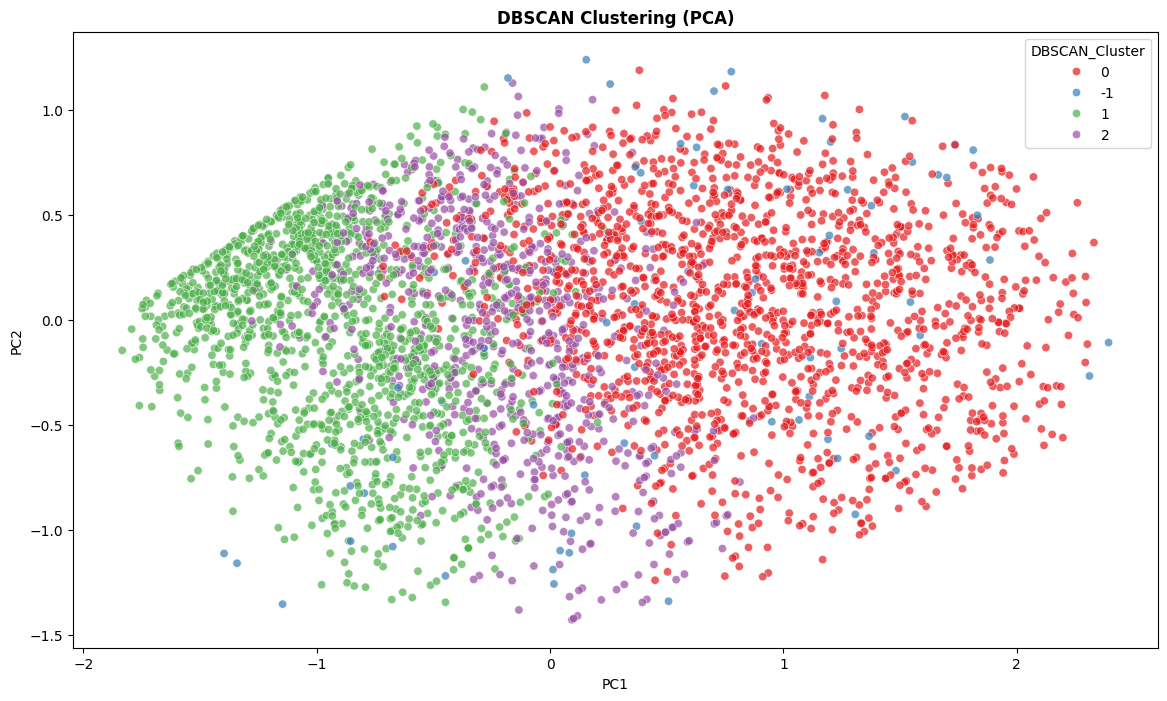

In [185]:
# PCA visualization - DBSCAN
rfm_pca_df['DBSCAN_Cluster'] = labels_dbscan.astype('str')

plt.figure(figsize = (14,8))
sns.scatterplot(
    data = rfm_pca_df,
    x = 'PC1',
    y = 'PC2',
    hue = 'DBSCAN_Cluster',
    palette = 'Set1',
    alpha = 0.7
)

plt.title("DBSCAN Clustering (PCA)", fontweight = 'bold')
plt.show()

#### Hierarchical Clustering

In [158]:
# Fitting Agglomerative clustering
agglo = AgglomerativeClustering(
    n_clusters = 5,
    linkage = 'complete'
)

labels_agglo = agglo.fit_predict(rfm_scaled)

# Attaching labels
rfm_agglo = rfm_final.copy()
rfm_agglo['Cluster_agglo'] = labels_agglo
print(rfm_agglo['Cluster_agglo'].value_counts())

# Silhouette score 
silhouette_agglo = silhouette_score(
    rfm_scaled,
    labels_agglo
)
print(f"Agglomerative Silhouette Score: {silhouette_agglo:.4f}")
print(f"Nb. of clusters: {len(set(labels_agglo))}")


Cluster_agglo
2    1210
1    1067
0     823
3     535
4     269
Name: count, dtype: int64
Agglomerative Silhouette Score: 0.2003
Nb. of clusters: 5


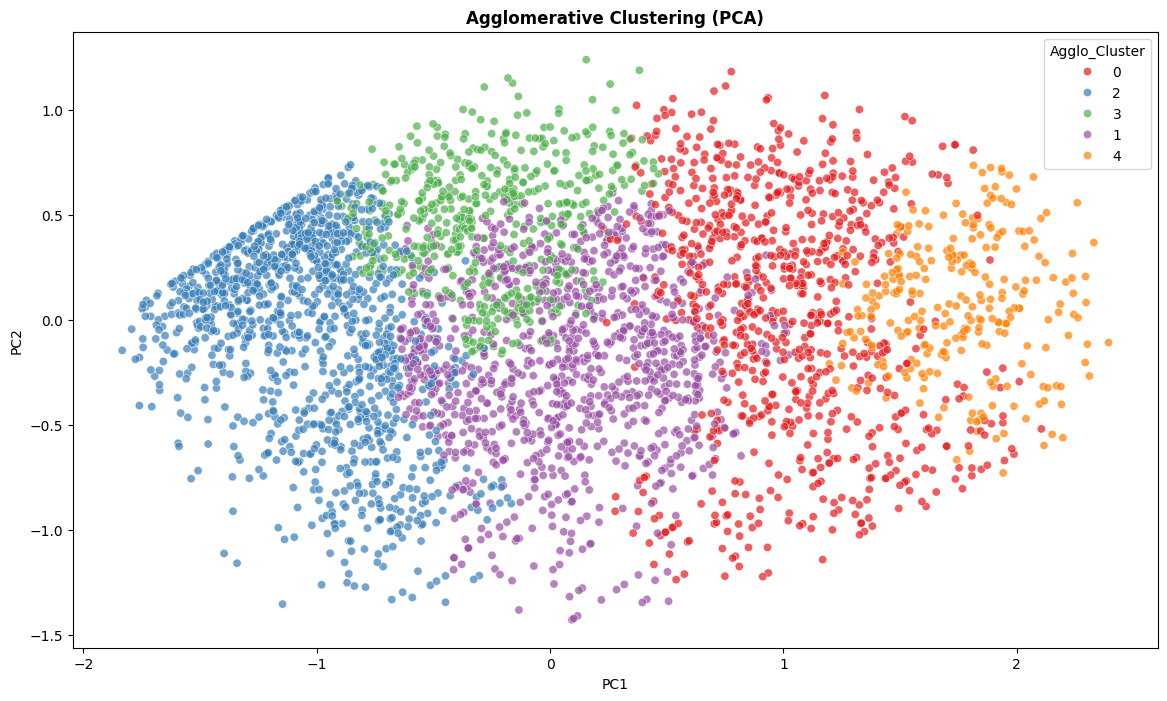

In [184]:
# PCA visualization - Agglomerative
rfm_pca_df['Agglo_Cluster'] = labels_agglo.astype('str')

plt.figure(figsize = (14,8))
sns.scatterplot(
    data = rfm_pca_df,
    x = 'PC1',
    y = 'PC2',
    hue = 'Agglo_Cluster',
    palette = 'Set1',
    alpha = 0.7
)
plt.title("Agglomerative Clustering (PCA)", fontweight = 'bold')
plt.show()

#### Summary comparison table w.r.t. different clustering approaches

In [187]:
comparison = pd.DataFrame({
    'Model': [
        'KMeans',
        'DBSCAN',
        'Agglomerative'
    ],
    'Silhouette Score': [
        silhouette_kmeans,
        silhouette_dbscan,
        silhouette_agglo
    ],
    'Nb. of Clusters': [
        labels_kmeans.nunique(),
        len(set(labels_dbscan)) - (1 if -1 in set(labels_dbscan) else 0),
        len(set(labels_agglo))
    ],
    'NoiseRatio (in %)': [
        0,
        100*((labels_dbscan == -1).sum() / labels_dbscan.shape[0]),
        0
    ]
})
#comparison['NoiseRatio (in %)'] = comparison['NoiseRatio (in %)'].round(4)
comparison

,Model,Silhouette Score,Nb. of Clusters,NoiseRatio (in %)
0,KMeans,0.322753,5,0.000000
1,DBSCAN,0.200029,3,1.997951
2,Agglomerative,0.200286,5,0.000000


### Testing Clusting Stability

We will apply Bootstrap Stability Test:

1. Randomly resampling customers (with replacement)

2. Refitting KMeans Clustering

3. Compare new vs existing labels

4. Adjusted Rand Index for measuring similarity


In [199]:
# baseline labels
X = rfm_scaled.copy()
y_existing = labels_kmeans.copy()

# bootstrapping randomly
n_iter = 100
ari_scores = []
for i in range(n_iter):
    X_resampled, y_resampled = resample(
        X,
        y_existing,
        replace = True,
        random_state = (7 + i)
    )

    # Refitting KMeans
    kmeans_bootstrap = KMeans(
        n_clusters = 5,
        random_state = 7,
        n_init = 20
    )

    labels_bootstrap = kmeans_bootstrap.fit_predict(X_resampled)

    # ARI score
    ari = adjusted_rand_score(
        labels_true = y_resampled,
        labels_pred = labels_bootstrap
    )
    ari_scores.append(ari)

# Summary
ari_scores = np.array(ari_scores)
print(f"Mean ARI: {ari_scores.mean():.4f}")
print(f"Std ARI: {ari_scores.std():.4f}")
print(f"Min ARI: {ari_scores.min():.4f}")
print(f"Max ARI: {ari_scores.max():.4f}")

Mean ARI: 0.9214
Std ARI: 0.0642
Min ARI: 0.4349
Max ARI: 0.9902


In [ ]:
# Stability verdict
def stabilityVerdict(ARI_mean):
    if ARI_mean >= 0.75:
        return "very stable"
    elif ARI_mean >= 0.6:
        return "stable"
    elif ARI_mean >= 0.45:
        return "moderately stable"
    else:
        return "unstable"
    
print(f"Stability Verdict:", stabilityVerdict(ari_scores.mean())) 

Stability Verdict: very stable


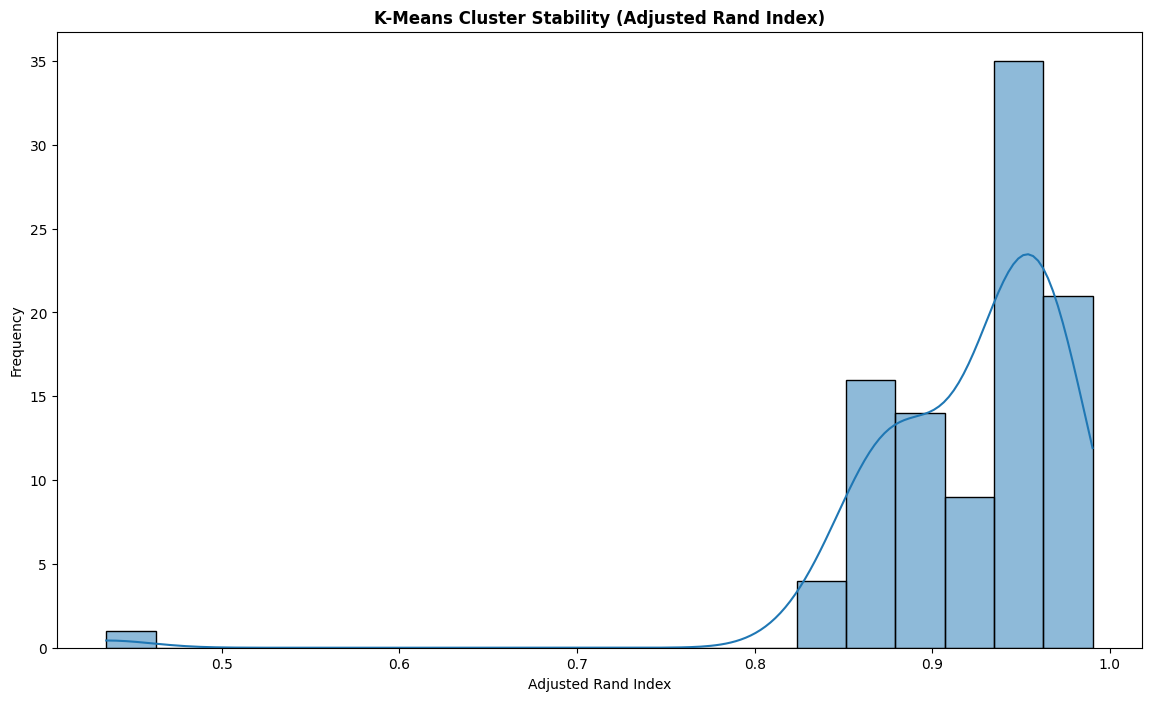

In [200]:
# Visualizing stability distribution
plt.figure(figsize = (14,8))
sns.histplot(
    ari_scores,
    bins = 20,
    kde = True
)

plt.title("K-Means Cluster Stability (Adjusted Rand Index)", fontweight = 'bold')
plt.xlabel("Adjusted Rand Index")
plt.ylabel("Frequency")
plt.show()